# Quality of the data in general


Here I plot graphs of peak I and FWHM variations for different cycles.
All data were reduced using the SPHERE DC without normalisation (which is useful for this case and will be performed later)
Apperture polarimetry

Works for all ZIMPOL data reduced with individual cycles


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import fnmatch
import os
from astropy.io import fits
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
from scipy import interpolate
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from textwrap import wrap
import scipy.ndimage as ndimage
from matplotlib.gridspec import GridSpec
from matplotlib import colors
import functions as f
import pandas as pd
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from matplotlib.ticker import ScalarFormatter,FormatStrFormatter,EngFormatter


In [2]:
def load_and_make_polar(dirdat,camera):
    dir = dirdat
    qfile = '*sci'+camera+'.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            iq = hdulq[0].data[0]
            q = hdulq[0].data[1]
            iu = hdulq[0].data[2]
            u = hdulq[0].data[3]
            n=q.shape[0]
             #Creating grid         
            xr = np.linspace(-n/2, n/2, num=n)
            yr = np.linspace(-n/2, n/2, num=n)
            x0 = 0.5
            y0 = 0.5
            xr = xr-x0
            yr = yr-y0
            Xr, Yr = np.meshgrid(xr, yr)
            R = np.sqrt(Xr**2 + Yr**2)
            phi = np.arctan(Yr/Xr)
            i=(iq+iu)/2
            q_phi=q*np.cos(2*phi)+u*np.sin(2*phi)
            q_phi = (q_phi > 0)*q_phi +  (q_phi <=0 )*1e-10
            u_phi=q*np.sin(2*phi)+u*np.cos(2*phi)
            pi=np.sqrt(q*q+u*u)
            aolp=0.5*np.arctan2(u, q)+np.pi/2
    return iq,q,iu,u,i,q_phi,u_phi,pi,aolp,R,phi


def load_and_make_polar_umon(dirdat,cycle,camera):
    #q
    dir = dirdat+'q_corr/'
    qfile = '*_'+cycle+'_'+camera+'.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            q = hdulq[0].data
            n=q.shape[0]
    #u
    dir = dirdat+'u_corr/'
    qfile = '*_'+cycle+'_'+camera+'.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            u = hdulq[0].data
    #qphi
    dir = dirdat+'qphi_corr/'
    qfile = '*_'+cycle+'_'+camera+'.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            qphi = hdulq[0].data
            
    #uphi
    dir = dirdat+'uphi_corr/'
    qfile = '*_'+cycle+'_'+camera+'.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            uphi = hdulq[0].data
            
            
            
    #iq,iu
    dir = dirdat+'sci/'
    qfile = '*_'+cycle+'_'+camera+'.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            iq = hdulq[0].data[0]
            iu = hdulq[0].data[2]
            
            
            
             #Creating grid         
            xr = np.linspace(-n/2, n/2, num=n)
            yr = np.linspace(-n/2, n/2, num=n)
            x0 = 0.5
            y0 = 0.5
            xr = xr-x0
            yr = yr-y0
            Xr, Yr = np.meshgrid(xr, yr)
            R = np.sqrt(Xr**2 + Yr**2)
            phi = np.arctan(Yr/Xr)
            
            i=(iq+iu)/2
            
            qphi = (qphi > 0)*qphi +  (qphi <=0 )*1e-10
            pi=np.sqrt(q*q+u*u)
            aolp=0.5*np.arctan2(u, q)+np.pi/2
            
    return iq,q,iu,u,i,qphi,uphi,pi,aolp,R,phi


def createfolder(dirName):
    try:
    # Create target Directory
       os.mkdir(dirName)
    except FileExistsError:
        print()#("Directory " , dirName ,  " already exists")   
        
        
def maskcrit(aolp,R):
    #this function creates a mask to show only  pixels with std of AoLP orientation for from 4 neighbouring pixels is less then median  
    phi = (aolp-90)  
    n=aolp.shape[0]
    critarray=np.zeros_like(phi)
    for ix in range (0,n):
        for iy in range(0,n):
            if phi[ix,iy]>180:
                phi[ix,iy]=phi[ix,iy]-180
            
    for ix in range (2,n-2):
        for iy in range(2,n-2):
            if R[ix,iy]>=1:            
                datapix=[]
                for (iix,iiy) in [(ix,iy),(ix-1,iy),(ix+1,iy),(ix,iy-1),(ix,iy+1)]: 
                    if R[iix,iiy]>=1:
                        datapix.append(abs(phi[iix,iiy]))
                            
                
                crit=np.std(datapix)               
                critarray[ix,iy]=crit
                
    for ix in range (0,n-1):
        for iy in range(0,n-1):
            if critarray[ix,iy]==0:
                critarray[ix,iy]=np.max(critarray)
    medianstd=np.nanmedian(critarray)
    
    mask=(critarray<=medianstd)#*R([ix,iy]>=1)
    return mask
        
def plot_AoLP(ps,R,Q,U,I,Q_PHI,PI,AOLP,title,save):
    # this function calculates DoLp and linear polarisation vectors on the background image.
    # The vectors are plotted for significant region and can be re-binned to show vector field more clearly.
    # First, we plot the background image
    fig = plt.figure(figsize=(8,8))
    i_plot = fig.add_subplot(111)
    n = I.shape[0]
    d = n * ps / 2

    im1=i_plot.imshow(np.arcsinh(Q_PHI), origin='lower',extent=(-d, d, d, -d))

    fig.colorbar(im1, orientation='vertical')

    plt.xlabel('mas')
    plt.ylabel("mas")
    plt.tight_layout(pad=0.1)     

    # ranges of the axis
    xx0, xx1 = i_plot.get_xlim()
    yy0, yy1 = i_plot.get_ylim()

    # binning factor
    factor = [4, 4]

    # re-binned number of points in each axis
    nx_new = PI.shape[1] // factor[0]
    ny_new = PI.shape[0] // factor[1]

    # These are the positions of the quivers (vector positions)
    X,Y = np.meshgrid(np.linspace(xx0,xx1,nx_new,endpoint=True),
                      np.linspace(yy0,yy1,ny_new,endpoint=True))
    # bin the data
    I_bin = I.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    Q_bin = Q.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    U_bin = U.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    Q_phi_bin = Q_PHI.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    PI_bin=PI.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    R_bin=R.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    aolp_bin=AOLP.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)

    # polarization angle
    psi=0.5*np.arctan2(U_bin, Q_bin)

    #psi=aolp_bin
    #i_plot.imshow(psi, origin='lower',extent=(-d, d, d, -d))

    # polarization fraction
    frac =Q_phi_bin/I_bin
    #frac=dolp_v[adc:bdc,adc:bdc]
    # mask to show only alighned

    mask1=maskcrit(psi,R_bin)
    mask2=Q_phi_bin>=10
    mask=mask2#*mask1
    #print('max DoLP in region %.3f percent'%(np.max(frac[mask])*100))

    #+pi/2 because quiver function start counting from the horizontal axis counterclockwise 
    #and the AoLP have to start from North to East (which is also counterclockvise)
    pixX = frac*np.cos(psi+np.pi/2) # X-vector 
    pixY = frac*np.sin(psi+np.pi/2) # Y-vector

    # keyword arguments for quiverplots
    quiveropts = dict(headlength=0, headwidth=1, pivot='middle', color='w')
    i_plot.quiver(X[mask], Y[mask], pixX[mask], pixY[mask],scale=2, **quiveropts)
    plt.title(title)
    plt.savefig(save,bbox_inches='tight', pad_inches=0.1)
    #plt.show()#(dirName+"aolp.png",bbox_inches='tight', pad_inches=0.1)
    plt.close()
    
def gaus(x,a,x0,sigma):
    # just a gaussian function for fitting
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

    
def find_FWHM (PSF,n,ps,figfolder,title): 
    # this function calculates FWHM of the PSF (resolution element of the data) and also plots the PSF profile in two directions
    middle=int(n/2)

    y1=PSF[middle,middle-60:middle+60]
    y2=PSF[middle-60:middle+60,middle]

    xdata = np.linspace(middle-60,middle+60, num=len(y1))


    n_gauss = len(xdata) #the number of data
    amp=np.max(y1)
    mean = np.sum(xdata * y1) / sum(y1)
    sigma = np.sqrt(sum(y1 * (xdata - mean)**2) / sum(y1))

    popt1,pcov1 = curve_fit(gaus,xdata,y1,p0=[amp,mean,sigma])
    popt2,pcov2 = curve_fit(gaus,xdata,y2,p0=[amp,mean,sigma])


    plt.plot(xdata, y1, 'o', label='vertical')
    plt.plot(xdata, gaus(xdata,*popt1), '-', label='fit1')
    plt.plot(xdata, y2, 'o', label='horizotal')
    plt.plot(xdata, gaus(xdata,*popt2), '-', label='fit2')
    plt.legend()
    plt.title(title)
    plt.savefig(figfolder+title+'.png',bbox_inches='tight', pad_inches=0.1)
    plt.close()

    fwhm1=2*np.sqrt(2*math.log(2))*popt1[2]
    fwhm2=2.355*popt2[2]


    fwhm=(abs(fwhm1)+abs(fwhm2))/2*ps

    return fwhm

def ap_fixed_in(rad,R,q,u,PSF):
    #this function calculates the flux in the aperture of setted outer radius            
    mask = (R <= rad)
    q_sum = np.sum(q[mask])
    u_sum = np.sum(u[mask])
    psf_sum = np.sum(PSF[mask])
    q_i_percent = q_sum / psf_sum * 100
    u_i_percent = u_sum / psf_sum * 100
    return psf_sum, q_sum, u_sum, q_i_percent, u_i_percent

def ap(radin,radout,R,q,u,PSF):
    #this function calculates the flux in the ring with setted inner and outer radius
    mask = (R <= radout) * (R >= radin)
    q_sum = np.sum(q[mask])
    u_sum = np.sum(u[mask])
    psf_sum = np.sum(PSF[mask])
    q_i_percent = q_sum / psf_sum * 100
    u_i_percent = u_sum / psf_sum * 100

    return psf_sum, q_sum, u_sum, q_i_percent, u_i_percent

In [3]:
#this are all target names (in my case they also correspind to directories) you have in your data folder
#star='IRAS08544-4431'  'HD83878'   'HD75885' 'AR_Pup'
#stars=['HR4049_20190108','HR4049_20190107','HR4226','HD71253','HD94680','HD96314','HD98025','V709_Car','HD75885', 'AR_Pup_dc_notnorm','UMon']

# target names you want to run script for 
stars=['AR_Pup_dc_notnorm']
# proper target names for plot titles
starnames = {'HD75885':'HD75885','AR_Pup':'AR_Pup','HR4049_20190108':'HR4049-2019-01-08','HR4049_20190107':'HR4049-2019-01-07','HR4049_combined':'HR4049',
             'IRAS08544-4431':'IRAS08544-4431','UMon':'UMon','AR_Pup_dc_notnorm':'AR_Pup','V709_Car':'V709_Car','HD71253':'HD71253','HR4226':'HR4226',
            'HD83878':'HD83878','HD71253':'HD71253','HD94680':'HD94680','HD96314':'HD96314','HD98025':'HD98025','UMon_Katya':'UMon_Katya'}
fittypes=['1', '2'] #fittypes are the camera types in ZIMPOL (there are two cameras with different filters)

band=['V','I'] #this are corresponding filters that were used for data I was working with. 
ps=3.6 #mas/pixel resolution of ZIMPOL



### Creating images

Directory  //media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Quality_indiv_cycles/AR_Pup_dc_notnorm/  already exists
                         reference  cycle  max_DoLP[%]  max_Q_phi   max_PI  \
0     AR_Pup_20c_00_17-19_not_norm     20       29.223    129.595  418.154   
1  AR_Pup_19c_00_15-17(1)_not_norm     19       25.836    106.546  114.686   
2  AR_Pup_18c_00_14-15(1)_not_norm     18       28.835     96.118  112.220   
3     AR_Pup_17c_00_12-13_not_norm     17       84.763    131.616  155.715   
4     AR_Pup_16c_00_10-11_not_norm     16       28.750    146.547  150.273   

   sumQ/I[%]  sumQ_phi/I[%]  sumPI/I[%]    FWHM  CNT60[%]  ...     3-30_PSF  \
0      6.065          4.837       7.910  71.074     0.003  ...  637736.6250   
1      5.689          4.798       7.811  71.687     0.004  ...  693699.5625   
2      5.831          4.657       7.573  72.841     0.004  ...  672761.6250   
3      5.859          5.407       8.327  66.119     0.005  ...  791046.8750   
4      5.6

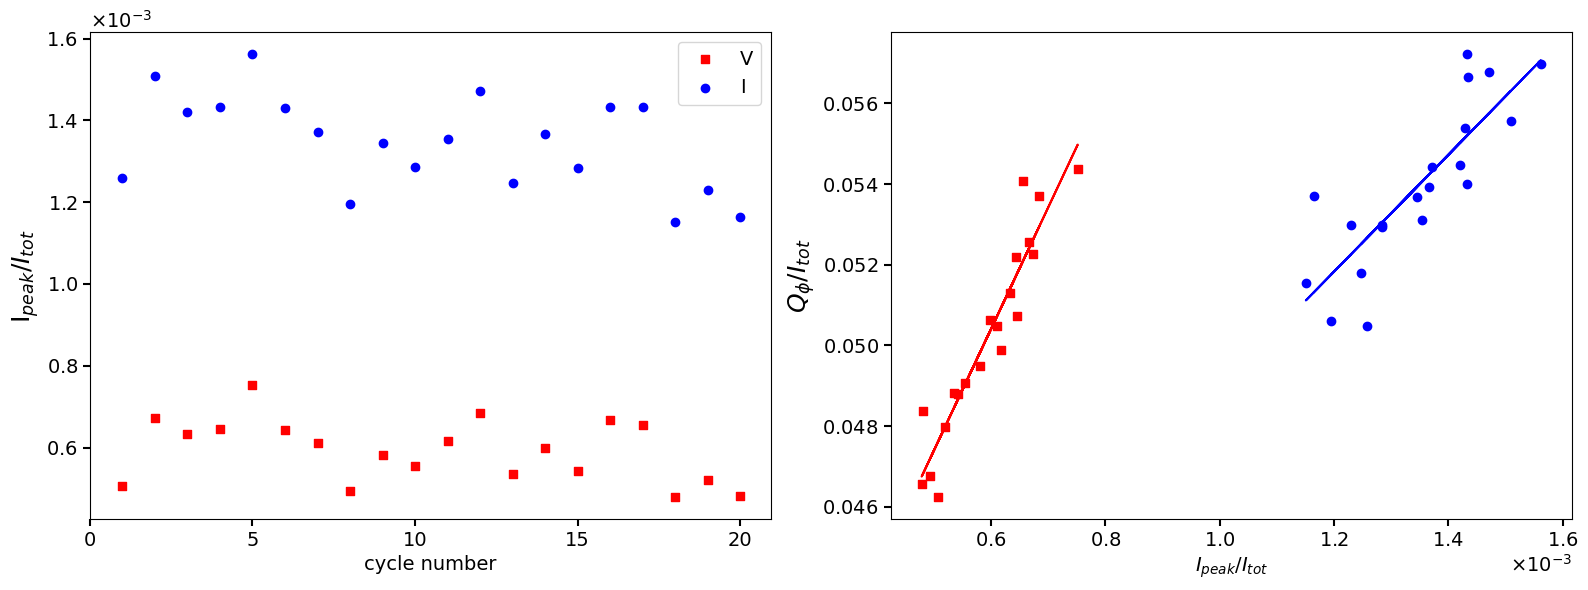

In [12]:
for star in stars:
    #here are just correct locations of the files and directories, also after initial reduction I had every polarimetric cycle in separate directory, so there is also file with list of directories an cycle numbers
    if star=='AR_Pup':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/AR_Pup/Normalised/'  #For AR_Pup
        input_filename =dirdat+'AR_Pup_indiv_process_list.csv'
    elif star=='AR_Pup_dc_notnorm':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/AR_Pup/Not_normalised/'  #For AR_Pup
        input_filename =dirdat+'AR_Pup_no_norm_indiv_process_list.csv'


    elif star=='IRAS08544-4431':

        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/IRAS08544-4431/Normalised/'  #For IRAS08
        input_filename =dirdat+'IRAS08process_list.csv'
    elif star=='IRAS08544-4431_dc_notnorm':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/IRAS08544-4431/Not_normalised/'  #For IRAS08
        input_filename =dirdat+'IRAS08_not_norm_indiv_process_list.csv'
    
    elif star=='UMon':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/UMon_data/HansMartin/'
        input_filename =dirdat+'UMon_cycle_list.csv'
        
    else:
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/'+star+'/' 
        input_filename =dirdat+'process_list.csv'
  
  
    figfolder0='//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Quality_indiv_cycles/'+ star+'/'
    
    specific_folder='//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Quality_indiv_cycles/'+star+'/'   #dirdat+'quality/'
    
    try:
    # Create target Directory
       os.mkdir(specific_folder)
    except FileExistsError:
        print("Directory " , specific_folder,  " already exists")
        
    output_filename = figfolder0+star+'_V_Original_AP_per_cycle.txt'
    df_orig_v = pd.read_csv(output_filename, delim_whitespace=True)
    output_filename = figfolder0+star+'_I_Original_AP_per_cycle.txt'
    df_orig_i = pd.read_csv(output_filename, delim_whitespace=True)
  
    output_filename = figfolder0+star+'_0-3_V_AP_per_cycle.txt'
    df_0_3_v = pd.read_csv(output_filename, delim_whitespace=True)
    output_filename = figfolder0+star+'_0-3_I_AP_per_cycle.txt'
    df_0_3_i = pd.read_csv(output_filename, delim_whitespace=True)
 
    print(df_orig_v.head())
    
 
   
   
    
    #for paper
    plt.figure(figsize=(16, 6))
    
    # Subplot 1: Peak I
    plt.subplot(1, 2, 1)
    plt.scatter(df_orig_v['cycle'], df_orig_v['Peak_i(Strehl)'],marker='s', label='V',color='red')
    plt.scatter(df_orig_i['cycle'], df_orig_i['Peak_i(Strehl)'], label='I',color='blue')
    plt.ylabel('I$_{peak}/I_{tot}$', fontsize=18)
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.gca().yaxis.offsetText.set_fontsize(14)
    plt.xlabel("cycle number", fontsize=14)  
    
    plt.xticks(ticks=range(np.min(df_orig_v['cycle'])-1, np.max(df_orig_v['cycle'])+1, 5), fontsize=14)
    plt.tick_params(axis='both', labelbottom=True,length=5,width=1.5,labelsize=14)  # Remove labeled ticks on the x-axis
    plt.legend(fontsize=14)

    # Subplot 2: Qphi
    plt.subplot(1, 2, 2)
    plt.scatter(df_orig_v['Peak_i(Strehl)'], df_orig_v['sumQ_phi/I[%]']/100,marker='s',color='red')
    slope, intercept = np.polyfit(df_orig_v['Peak_i(Strehl)'], df_orig_v['sumQ_phi/I[%]']/100, deg=1)
    plt.plot(df_orig_v['Peak_i(Strehl)'],slope*df_orig_v['Peak_i(Strehl)']+intercept,color='red')
    plt.scatter(df_orig_i['Peak_i(Strehl)'], df_orig_i['sumQ_phi/I[%]']/100,color='blue')
    slope, intercept = np.polyfit(df_orig_i['Peak_i(Strehl)'], df_orig_i['sumQ_phi/I[%]']/100, deg=1)
    plt.plot(df_orig_i['Peak_i(Strehl)'],slope*df_orig_i['Peak_i(Strehl)']+intercept,color='blue')
    plt.ylabel('$Q_{\phi}/I_{tot}$', fontsize=18)
    plt.xlabel("$I_{peak}/I_{tot}$", fontsize=14)  
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-1, 2))
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.gca().yaxis.offsetText.set_fontsize(14)
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.gca().xaxis.offsetText.set_fontsize(14)
    #plt.xticks(ticks=range(np.min(df_orig_v['cycle'])-1, np.max(df_orig_v['cycle'])+1, 5), fontsize=14)
    plt.tick_params(axis='both',length=5,width=1.5,labelsize=14) 
   
    # Adjust x-axis limits to include the last tick
    #plt.xlim(np.min(df_orig_v['cycle'])-1, np.max(df_orig_v['cycle'])+1)
    plt.tight_layout()
    plt.savefig(specific_folder + star + '_for_thesis.png', bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()